# Importando as bibliotecas:

In [4]:
# Bibliotecas de aprendizado de máquina:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

# Bibliotecas de processamento de áudio:
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import Audio

# Bibliotecas de processamento de sinais e análise estatística:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas de manipulação de arquivos e compactação:
import zipfile
import os
from google.colab import drive

# Baixando e descompactando o dataset:

In [5]:
drive.mount('/content/drive')

caminho_zip = '/content/drive/MyDrive/Audios.zip'
diretório_destino = '/content/audios_descompactados'

with zipfile.ZipFile(caminho_zip, 'r') as zip_ref:
    zip_ref.extractall(diretório_destino)

# Verificar os arquivos descompactados
arquivos_descompactados = os.listdir(diretório_destino)
print("Descompactação concluida")

Mounted at /content/drive
Descompactação concluida


# Carregando os dados para estruturas:

In [6]:
# Diretórios para cada tipo de áudio
dir_ambulance = '/content/audios_descompactados/Audios/ambulance/'
dir_firetruck = '/content/audios_descompactados/Audios/firetruck/'
dir_police = '/content/audios_descompactados/Audios/police/'
dir_traffic = '/content/audios_descompactados/Audios/traffic/'

# Dicionário para armazenar os vetores de áudio para cada tipo
audio_por_tipo = {}
sr_por_tipo = {}

# Carregamento de áudios para cada tipo
for tipo, diretorio in [("ambulance", dir_ambulance), ("firetruck", dir_firetruck), ("police", dir_police), ("traffic", dir_traffic)]:
    # Lista para armazenar os vetores de áudio para este tipo
    vetores_audio = []
    sample_rates = []
    # Percorre os arquivos de áudio dentro deste tipo
    for arquivo in os.listdir(diretorio):
        if arquivo.endswith('.wav'):
            # Caminho completo do arquivo
            caminho_arquivo = os.path.join(diretorio, arquivo)
            # Carrega o áudio e converte para um vetor numpy
            audio, srt = librosa.load(caminho_arquivo, sr=None)
            vetores_audio.append(audio)
            sample_rates.append(srt)
    # Armazena os vetores de áudio para este tipo no dicionário
    audio_por_tipo[tipo] = vetores_audio
    sr_por_tipo[tipo] = sample_rates

# Exemplo de uso dos vetores de áudio carregados
print("Número de áudios do tipo 'ambulance':", len(audio_por_tipo['ambulance']))
print("Número de áudios do tipo 'traffic':", len(audio_por_tipo['traffic']))
print("Número de áudios do tipo 'police':", len(audio_por_tipo['police']))
print("Número de áudios do tipo 'firetruck':", len(audio_por_tipo['firetruck']))

Número de áudios do tipo 'ambulance': 400
Número de áudios do tipo 'traffic': 421
Número de áudios do tipo 'police': 454
Número de áudios do tipo 'firetruck': 400


# Analisando amostras:

In [ ]:
# Selecionando um áudio de cada tipo para reprodução
audio_ambulance, sr_ambulance = audio_por_tipo['ambulance'][0], sr_por_tipo['ambulance'][0]
audio_traffic, sr_traffic = audio_por_tipo['traffic'][0], sr_por_tipo['traffic'][0]
audio_police, sr_police = audio_por_tipo['police'][0], sr_por_tipo['police'][0]
audio_firetruck, sr_firetruck = audio_por_tipo['firetruck'][0], sr_por_tipo['firetruck'][0]

# Reproduzindo os áudios
print("Áudio do tipo 'ambulance':")
display(Audio(audio_ambulance, rate=sr_ambulance)) # O parâmetro 'rate' é a taxa de amostragem do áudio
print("Áudio do tipo 'traffic':")
display(Audio(audio_traffic, rate=sr_traffic))
print("Áudio do tipo 'police':")
display(Audio(audio_police, rate=sr_police))
print("Áudio do tipo 'firetruck':")
display(Audio(audio_firetruck, rate=sr_firetruck))

Áudio do tipo 'ambulance':


Áudio do tipo 'traffic':


Áudio do tipo 'police':


Áudio do tipo 'firetruck':


# Plotando o gráfico temporal da onda:

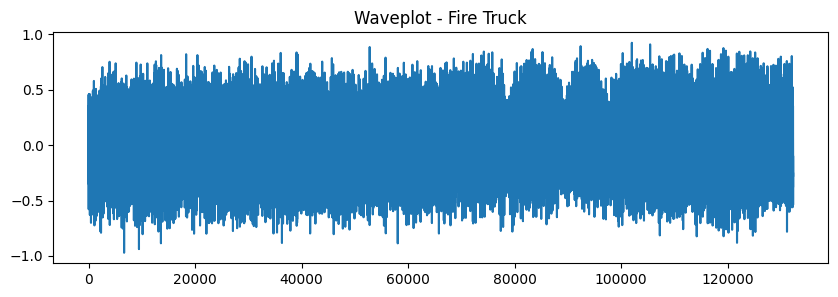

In [ ]:
# Plot the audio file
plt.figure(figsize=(10, 3))
plt.plot(audio_firetruck)
plt.title('Waveplot - Fire Truck')
plt.show()

# Plotando o spectograma de Mel da onda:

# Definindo as funções de extração de features:

In [ ]:
# Normalizando os dados
scaler = MinMaxScaler()

In [ ]:
def property_features(array):
    mean = np.mean(array)
    median = np.median(array)
    max_val = np.max(array)
    min_val = np.min(array)
    var = np.var(array)
    std = np.std(array)
    range_val = max_val - min_val
    coef = (std/mean) * 100

    values = scaler.fit_transform([[mean, median, max_val, min_val, var, std, range_val, coef]])

    return values

In [ ]:
def extract_features_from_audio(audio_data, sr):
    # Calcula a Transformada de Fourier
    fft_features = np.abs(fft(audio_data))

    # Calcula os coeficientes cepstrais de frequência de Mel (MFCC)
    mfcc_features = librosa.feature.mfcc(y=audio_data, sr=sr)

    # Calcula o centroide espectral
    spectral_centroid = librosa.feature.spectral_centroid(y=audio_data, sr=sr)

    # RMS - Root Mean Square
    rms = librosa.feature.rms(y=audio_data)

    # ZCR -Taxa de Cruzamento por Zero
    zcr = librosa.feature.zero_crossing_rate(y=audio_data)

    # MEL - Espectrograma Mel
    mel = librosa.feature.melspectrogram(y=audio_data)

    final_array = (property_features(fft_features) +
    property_features(mfcc_features) +
    property_features(spectral_centroid) +
    property_features(rms) +
    property_features(zcr) +
    property_features(mel))

    return final_array

In [ ]:
def extract_features_from_audio_list(audio_list, sr_list, classe):
  dataset = []
  for audio_data, sr in zip(audio_list, sr_list):
      output = extract_features_from_audio(audio_data, sr)
      dataset.append((torch.tensor(output), torch.tensor(classe)))

  return dataset

# Processando todo o dataset para um único vetor no formato: [([caracteristicas],classe),...]

In [ ]:
classes = ['ambulance', 'traffic', 'police', 'firetruck']

dataset = []

for classe in classes:
  if classe == 'ambulance':
    dataset += extract_features_from_audio_list(audio_por_tipo[classe], sr_por_tipo[classe], 0)
  elif classe == 'traffic':
    dataset += extract_features_from_audio_list(audio_por_tipo[classe], sr_por_tipo[classe], 1)
  elif classe == 'police':
    dataset += extract_features_from_audio_list(audio_por_tipo[classe], sr_por_tipo[classe], 2)
  else:
    dataset += extract_features_from_audio_list(audio_por_tipo[classe], sr_por_tipo[classe], 3)

print("Tamanho do nosso vetor de dados: {}".format(len(dataset)))

Tamanho do nosso vetor de dados: 1675


# Dividindo o conjunto entre treino, teste e validação:

In [ ]:
dados_treino = []
dados_teste = []
dados_validacao = []

dados_treino, dados_teste = train_test_split(dataset, test_size=0.2, random_state=42, shuffle=True)
dados_teste, dados_validacao = train_test_split(dados_teste, test_size=0.5, random_state=42, shuffle=True)

# Exibindo o número de dados
print("Amostras de treino : {}\nAmostras de teste : {}\nAmostras validação: {}".format(len(dados_treino), len(dados_teste), len(dados_validacao)))

# Criando um DataLoader para facilitar o treinamento dividindo todo o dataset em lotes
train_loader = DataLoader(dataset=dados_treino, batch_size=8, shuffle=True)
valid_loader = DataLoader(dataset=dados_validacao, batch_size=8, shuffle=False)
test_loader = DataLoader(dataset=dados_teste, batch_size=8, shuffle=False)

Amostras de treino : 1340
Amostras de teste : 167
Amostras validação: 168


# Criando nosso modelo MLP:

In [ ]:
# Definindo a arquitetura da rede neural
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        return x

# Definindo os algoritmos de treino, teste e validação:

In [ ]:
def validacao(modelo, valid_loader, criterio):
    modelo.eval()  # Define o modelo no modo de avaliação
    valid_loss = 0.0

    with torch.no_grad():  # Desativa o cálculo do gradiente durante a validação
        for data in valid_loader:
            inputs, labels = data
            inputs = inputs.to(torch.float32)

            outputs = modelo(inputs)
            loss = criterio(outputs, labels)
            valid_loss += loss.item()

    # Calcula a média das perdas durante a validação
    avg_valid_loss = valid_loss / len(valid_loader)

    return avg_valid_loss

In [ ]:
def Treinamento(epocas, modelo, train_loader, valid_loader, criterio, otimizador):
  train_loss_array = []
  valid_loss_array = []
  for epoch in range(epocas):
      epoch_loss = 0.0  # Inicializa/zera a loss para a época
      for data in train_loader:
          inputs, labels = data
          inputs = inputs.to(torch.float32)
          otimizador.zero_grad()
          outputs = modelo(inputs)
          loss = criterio(outputs, labels)
          loss.backward()
          otimizador.step()
          epoch_loss += loss.item()  # Acumula a loss para a época

      # Calculando a média da loss para a época
      avg_epoch_loss = epoch_loss / len(train_loader)
      train_loss_array.append(avg_epoch_loss)

      # Calculando a loss média para o conjunto de validação
      avg_valid_loss = validacao(modelo, valid_loader, criterio)
      valid_loss_array.append(avg_valid_loss)

      # Exibindo a loss média para a época
      if (epoch+1)%50 == 0:
        print(f'Época {epoch + 1}/{epocas}, Loss de treinamento média: {avg_epoch_loss:.3f}, Loss de validação média: {avg_valid_loss:.3f}')

  return modelo, train_loss_array, valid_loss_array

In [ ]:
# Avaliando o modelo no conjunto de teste
def Teste_modelo(modelo, test_loader, classes):
  modelo.eval()
  y_true = []
  y_pred = []
  correct = 0
  total = 0
  with torch.no_grad():
      for data in test_loader:
          inputs, labels = data
          inputs = inputs.to(torch.float32)
          outputs = modelo(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          y_true.extend(labels.cpu().numpy())
          y_pred.extend(predicted.cpu().numpy())

  accuracy = correct / total
  print(f'Acurácia no teste: {accuracy * 100:.2f}%')
  print("\n")

  cm = confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Matriz de confusão')
  plt.show()

In [ ]:
def plotagem_losses(train_losses, valid_losses):
  # Plotando as perdas para k épocas
  plt.plot(range(1, len(train_losses) + 1), train_losses, label='Loss de treinamento')
  plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Loss de validação')
  plt.title(f'Loss para as {len(train_losses)} épocas')
  plt.xlabel('Épocas')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

# Treinando e analisando métricas retornadas a partir do treino:

In [ ]:
# Parâmetros do modelo:
entrada = len(dados_treino[0][0])
saida = len(classes)
oculta = 4092

# Instância e atributos:
modelo = MLP(entrada, oculta, saida)
lr_rate = 4e-6
criterio = nn.CrossEntropyLoss()
otimizador = optim.Adam(modelo.parameters(), lr=lr_rate, weight_decay=5e-3)

# Épocas de treinamento:
epocas = 1000

In [ ]:
# Treinamento do modelo
modelo, train_losses, valid_losses = Treinamento(epocas, modelo, train_loader, valid_loader, criterio, otimizador)
print("\n")

# Plotando o gráfico de losses:
plotagem_losses(train_losses, valid_losses)
print("\n")

# Acurácia do modelo criado:
Teste_modelo(modelo, test_loader, classes)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (8x8 and 1x4092)

# Áudio aleatório para processamento e predição com o modelo:

In [ ]:
# Escolhendo aleatoriamente uma classe
classe_aleatoria = random.choice(classes)
indice_aleatorio = random.randint(0, len(audio_por_tipo[classe_aleatoria]))

print("Classe aleatória escolhida: {}, numero de áudios na classe: {}, indice do audio escolhido: {}".format(classe_aleatoria, len(audio_por_tipo[classe_aleatoria]), indice_aleatorio))

audio_escolhido, sr_escolhido = audio_por_tipo[classe_aleatoria][indice_aleatorio], sr_por_tipo[classe_aleatoria][indice_aleatorio]

print("\nÁudio escolhido:")
display(Audio(audio_escolhido, rate=sr_escolhido))

# Processando nosso áudio escolhido:
caracteristicas = extract_features_from_audio(audio_escolhido, sr_escolhido)
caracteristicas = torch.tensor(caracteristicas)

In [ ]:
# Função para realizar previsão em um novo dado
def Predicao(modelo, entrada, rotulo, classes):
  modelo.eval()
  with torch.no_grad():
      entrada = entrada.to(torch.float32)
      outputs = modelo(entrada)
      _, prevista = torch.max(outputs.data, 0)  # Removendo a dimensão especificada
      prevista = classes[prevista.item()]  # Acessando o item previsto

      print("Classe prevista: {}, Classe real: {}".format(prevista, rotulo))

In [ ]:
# Realizando a predição:
Predicao(modelo, caracteristicas, classe_aleatoria, classes)